In [1]:
import matplotlib.pyplot as plt
import numpy as np

from PIL import Image

import torch
from torchvision import models

from captum.attr import  GuidedBackprop

# Helper functions
import sys
sys.path.append('../')

from utils.visualise import display_imagenet_output, process_attributions
from utils.datasets import preprocess_imagenet_image

# Load model and sample image

In [2]:
# Download example image
import sys
sys.path.append('../')

from utils.download import save_image

url = "https://upload.wikimedia.org/wikipedia/commons/thumb/4/4b/Israel-2013-Makhtesh_Ramon_02_%28Ibex%29.jpg/500px-Israel-2013-Makhtesh_Ramon_02_%28Ibex%29.jpg"
save_image(url, "goat.png")

Figure saved to /Users/conorosullivan/Documents/XAI/smoothgrad_input.pdf


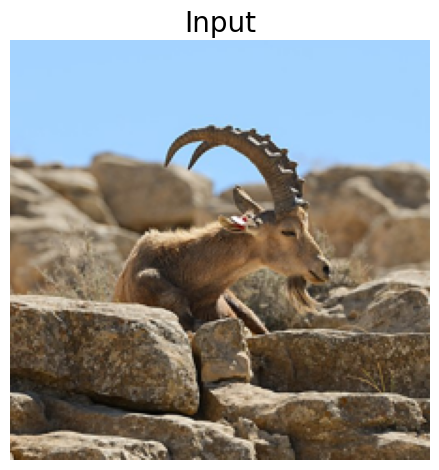

In [9]:
# Load a sample image
img_path = "goat.png"
img = Image.open(img_path).convert("RGB")

plt.imshow(img)
plt.title("Input")
plt.axis('off')

In [3]:
# Load the pre-trained model (e.g., ResNet50)
model = models.resnet50(pretrained=True)

# Set the model to gpu
device = torch.device('mps' if torch.backends.mps.is_built()
                      else 'cuda' if torch.cuda.is_available()
                      else 'cpu')
model.to(device)

# Set the model to evaluation mode
model.eval()
model.zero_grad()

/Users/conorosullivan/Documents/git/XAI-for-CV/cv_xai_venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/conorosullivan/Documents/git/XAI-for-CV/cv_xai_venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
# Preprocess the image
original_img_tensor = preprocess_imagenet_image(img_path)
original_img_tensor = original_img_tensor.to(device)

# Clone tensor to avoid in-place operations
img_tensor = original_img_tensor.clone()
img_tensor.requires_grad_() # Enable gradient tracking

predictions = model(img_tensor)

# Decode the output
display_imagenet_output(predictions,n=5)

ibex 0.999991774559021
bighorn 6.572903203050373e-06
ram 7.691302812418144e-07
hare 2.8964134912712325e-07
impala 2.4532033648938523e-07


tensor(350, device='mps:0')

## SmoothGrad + Standard Backpropogation

In [6]:
# Reset gradients
model.zero_grad()

# We will use this class for all gradient computations
target_class = predictions.argmax()

# Compute gradients w.r.t to logit by performing backward pass
predictions[:, target_class].backward()

In [7]:
# Get the gradients
standard_backprop_grads = img_tensor.grad.detach().cpu().numpy()

grads = standard_backprop_grads[0].copy()
grads = process_attributions(grads, activation="abs",skew= 0.5, colormap="viridis")

In [8]:
# Parameters
n_samples = 50         # number of noisy samples
noise_sigma = 0.15       # relative standard deviation of Gaussian noise (e.g., 15% of input range)

# Clone tensor for gradient computation
img_tensor = original_img_tensor.clone()
img_tensor.requires_grad_()

# SmoothGrad computation
smooth_grads = torch.zeros_like(img_tensor)

for i in range(n_samples):
    # Add Gaussian noise
    noise = torch.randn_like(img_tensor) * noise_sigma * img_tensor.std()
    noisy_img = (img_tensor + noise).detach()
    noisy_img.requires_grad_()

    # Forward pass
    preds = model(noisy_img)

    # Zero grads
    model.zero_grad()

    # Backward pass for the target class
    preds[:, target_class].backward()

    # Accumulate gradients
    smooth_grads += noisy_img.grad.detach()

# Average the gradients
smooth_grads /= n_samples

# Convert to numpy
smooth_grads_np = smooth_grads.detach().cpu().numpy()[0].copy()

Figure saved to /Users/conorosullivan/Documents/XAI/smoothgrad_standard_backprop.pdf


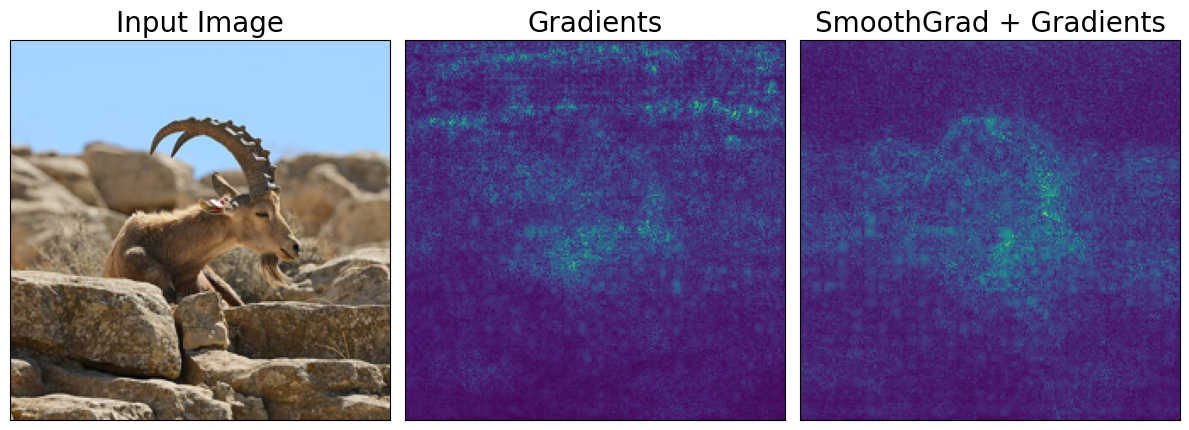

In [10]:
# Process attribution map (same as your existing function)
smoothgrad_map = process_attributions(smooth_grads_np, activation="abs", skew=0.5, colormap="viridis")

# Visualization
fig, ax = plt.subplots(1, 3, figsize=(12, 6))
ax[0].imshow(img)
ax[0].set_title("Input Image")
ax[1].imshow(grads)
ax[1].set_title("Gradients")
ax[2].imshow(smoothgrad_map)
ax[2].set_title(f"SmoothGrad + Gradients")

for a in ax:
    a.set_xticks([])
    a.set_yticks([])

## SmoothGrad + Guided Backpropagation

In [11]:
img_tensor = original_img_tensor.clone()
img_tensor.requires_grad_()

#  Guided Backprop
guided_bp = GuidedBackprop(model)
gb_attr = guided_bp.attribute(img_tensor, target=target_class)

gb_attr = process_attributions(gb_attr, activation="abs", skew=0.5, colormap="viridis")

/Users/conorosullivan/Documents/git/XAI-for-CV/cv_xai_venv/lib/python3.11/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:66: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


In [12]:
n_samples = 50         # number of noisy samples
noise_sigma = 0.1       # relative standard deviation of Gaussian noise (e.g., 15% of input range)

# SmoothGrad + Guided Backpropagation
smooth_grads_gb = torch.zeros_like(img_tensor)
for i in range(n_samples):
    # Add Gaussian noise
    noise = torch.randn_like(img_tensor) * noise_sigma * img_tensor.std()
    noisy_img = (img_tensor + noise).detach()
    noisy_img.requires_grad_()

    # Guided Backpropagation
    guided_bp = GuidedBackprop(model)
    gb_attr_noisy = guided_bp.attribute(noisy_img, target=target_class)

    # Accumulate gradients
    smooth_grads_gb += gb_attr_noisy.detach()

# Average the accumulated gradients
smooth_grads_gb /= n_samples
# Convert to numpy
smooth_grads_gb_np = smooth_grads_gb.detach().cpu().numpy()[0]
# Process attribution map
smoothgrad_gb_map = process_attributions(smooth_grads_gb_np, activation="abs", skew=0.5, colormap="viridis")

Figure saved to /Users/conorosullivan/Documents/XAI/smoothgrad_guided_backprop.pdf


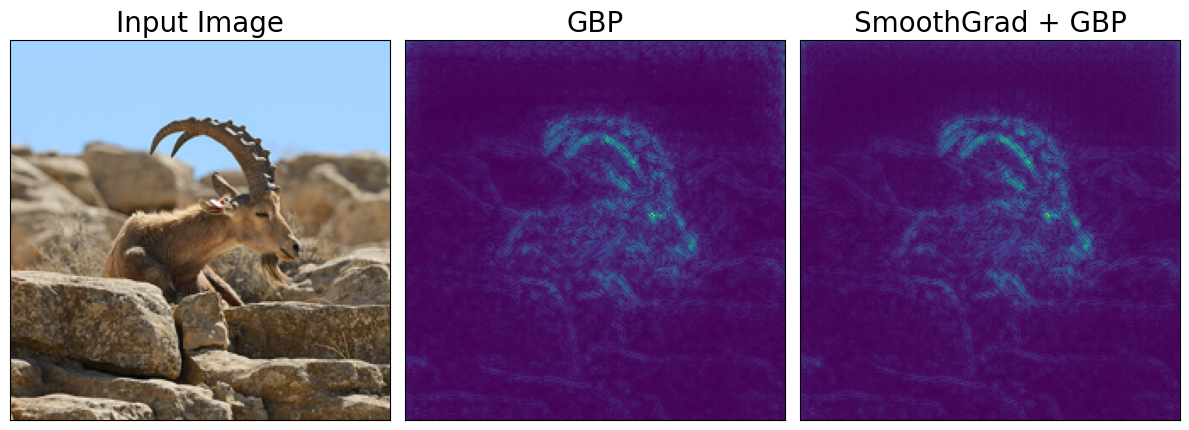

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(12, 6))

ax[0].imshow(img)
ax[0].set_title("Input Image")

ax[1].imshow(gb_attr)
ax[1].set_title("GBP")

ax[2].imshow(smoothgrad_gb_map)
ax[2].set_title("SmoothGrad + GBP")

for a in ax:
    a.set_xticks([])
    a.set_yticks([])